# Resnet decreasing training time

This python code is just an experiment to speed of training time by using Tensroflow's XLA, a domain-specific compiler for linear algebra that can accelerate TensorFlow models with so source code changes. I also use mixed precision training which is a method to train models using 16-bit float number(half-precision) vs 32-bit float number(single precision). By using half-precision we use less memory and also reduce time when doing calculation. Both these two methods can bring great improvements depending on the situation. XLA can bring up to 7 times performance improvement while half-precision can bring 3 times of an improvement.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import mixed_precision

In [2]:
# Using Tensorflow-2.4.x
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=10,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [4]:
train_gen = train_datagen.flow_from_directory('../input/intel-image-classification/seg_train/seg_train', 
                                              target_size=(128,128),
                                              batch_size=64)

Found 14034 images belonging to 6 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale=1./255.)

In [6]:
test_gen = test_datagen.flow_from_directory('../input/intel-image-classification/seg_test/seg_test',
                                            target_size=(128,128),
                                            batch_size=64)

Found 3000 images belonging to 6 classes.


In [7]:
valid_gen = test_datagen.flow_from_directory('../input/intel-image-classification/seg_test/seg_test',
                                            target_size=(128,128))

Found 3000 images belonging to 6 classes.


In [8]:
resnet_model = ResNet50(include_top=False, input_shape=(128,128,3))

In [9]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
class my_acc_callback(tf.keras.callbacks.Callback):
 
    def on_epoch_end(self,epoch, logs={}):
        threshold = 0.95
        if logs.get('acc') >= threshold:  # change to 'acc' if you get NoneType and float error
            print('\naccuracy is greater than {}'.format(threshold))
            self.model.stop_training = True

In [11]:
callback = my_acc_callback()

In [12]:
def plot(history, info_type='loss'):

    """
    history: the history callback from a model.fit
    info_type: what you want to show. (e.g. 'loss', 'acc', 'accuracy')
    """
    plt.plot(history.history[info_type], label=[info_type])
    try:
        plt.plot(history.history['val_' + info_type], label=['val_' + info_type])
    except Exception:
        print(f'no val_{info_type}')
    plt.title(info_type)
    plt.legend()
    

In [13]:
def make_model():
    tf.random.set_seed(100)
    resnet_model = ResNet50(include_top=False, input_shape=(128,128,3))

    resnet = tf.keras.Sequential([
        resnet_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu', activity_regularizer=L2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu', activity_regularizer=L2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', activity_regularizer=L2(0.01)),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    return resnet


In [14]:
tf.config.optimizer.get_jit() 

False

In [15]:
mixed_precision.global_policy()

<Policy "float32">

In [16]:
resnet = make_model()

In [17]:
resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [18]:
weights = resnet.get_weights()

In [19]:
resnet.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['acc'])

In [20]:
%time r = resnet.fit(train_gen, epochs=100, workers=12, callbacks=[callback])

Epoch 1/100
220/220 [==============================] - 53s 197ms/step - loss: 3.1184 - acc: 0.1826
Epoch 2/100
220/220 [==============================] - 44s 193ms/step - loss: 1.7659 - acc: 0.2429
Epoch 3/100
220/220 [==============================] - 44s 193ms/step - loss: 1.5968 - acc: 0.3823
Epoch 4/100
220/220 [==============================] - 43s 192ms/step - loss: 1.3686 - acc: 0.4743
Epoch 5/100
220/220 [==============================] - 44s 193ms/step - loss: 1.2451 - acc: 0.4776
Epoch 6/100
220/220 [==============================] - 43s 192ms/step - loss: 1.1748 - acc: 0.4825
Epoch 7/100
220/220 [==============================] - 43s 192ms/step - loss: 1.1359 - acc: 0.4953
Epoch 8/100
220/220 [==============================] - 44s 193ms/step - loss: 0.9228 - acc: 0.6490
Epoch 9/100
220/220 [==============================] - 45s 197ms/step - loss: 0.8370 - acc: 0.6429
Epoch 10/100
220/220 [==============================] - 46s 203ms/step - loss: 0.7909 - acc: 0.6797
Epoch 11/

In [81]:
reg_time = (21*60) + 39

no val_loss


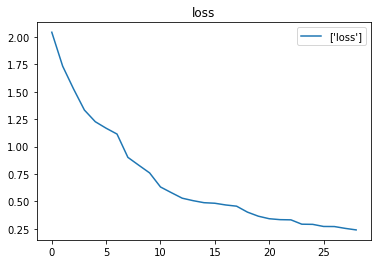

In [22]:
plot(r, info_type="loss")

no val_acc


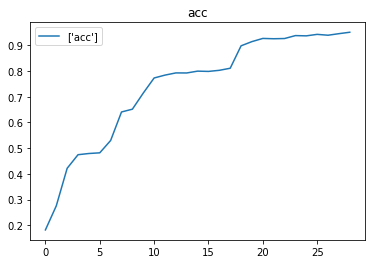

In [23]:
plot(r, info_type="acc")

In [24]:
scores = resnet.evaluate(valid_gen, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

94/94 [==============================] - 6s 44ms/step - loss: 0.3853 - acc: 0.9003
Test loss: 0.3853062391281128
Test accuracy: 0.9003333449363708


In [25]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True) 

In [26]:
tf.config.optimizer.get_jit() 

True

In [27]:
resnet.set_weights(weights)

In [28]:
resnet.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['acc'])

In [29]:
%time r = resnet.fit(train_gen, epochs=100, workers=12, callbacks=[callback])

Epoch 1/100
220/220 [==============================] - 76s 181ms/step - loss: 3.1092 - acc: 0.1765
Epoch 2/100
220/220 [==============================] - 64s 286ms/step - loss: 1.7588 - acc: 0.2576
Epoch 3/100
220/220 [==============================] - 41s 181ms/step - loss: 1.5777 - acc: 0.3907
Epoch 4/100
220/220 [==============================] - 41s 179ms/step - loss: 1.3640 - acc: 0.4748
Epoch 5/100
220/220 [==============================] - 40s 176ms/step - loss: 1.2552 - acc: 0.4830
Epoch 6/100
220/220 [==============================] - 41s 180ms/step - loss: 1.1852 - acc: 0.4826
Epoch 7/100
220/220 [==============================] - 41s 181ms/step - loss: 1.1489 - acc: 0.4837
Epoch 8/100
220/220 [==============================] - 42s 185ms/step - loss: 1.1188 - acc: 0.4884
Epoch 9/100
220/220 [==============================] - 41s 179ms/step - loss: 1.0247 - acc: 0.6143
Epoch 10/100
220/220 [==============================] - 40s 177ms/step - loss: 0.7191 - acc: 0.7640
Epoch 11/

In [80]:
XLA_time = (21*60) + 6

no val_loss


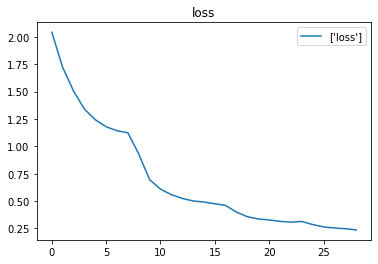

In [31]:
plot(r, info_type="loss")

no val_acc


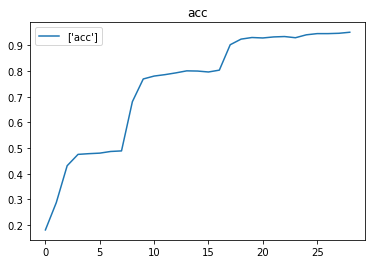

In [32]:
plot(r, info_type="acc")

In [33]:
scores = resnet.evaluate(valid_gen, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

94/94 [==============================] - 8s 33ms/step - loss: 0.3362 - acc: 0.9123
Test loss: 0.33620011806488037
Test accuracy: 0.9123333096504211


# Mixed Precision Notes
Mixed precision training is using half-precision for all layers except the input and output layers

## Increasing your batch size
If it doesn't affect model quality, try running with double the batch size when using mixed precision. As float16 tensors use half the memory, this often allows you to **double your batch size without running out of memory**. Increasing batch size typically increases training throughput, i.e. the training elements per second your model can run on.


## Ensuring GPU Tensor Cores are used
As mentioned previously, modern NVIDIA GPUs use a special hardware unit called Tensor Cores that can multiply float16 matrices very quickly. However, Tensor Cores requires certain dimensions of tensors to be a multiple of 8. In the examples below, an argument is bold if and only if it needs to be a multiple of 8 for Tensor Cores to be used.

tf.keras.layers.Dense(units=**64**) <br>
tf.keras.layers.Conv2d(filters=**48**, kernel_size=7, stride=3)<br>
And similarly for other convolutional layers, such as tf.keras.layers.Conv3d<br>
tf.keras.layers.LSTM(units=**64**)<br>
And similar for other RNNs, such as tf.keras.layers.GRU<br>
tf.keras.Model.fit(epochs=2, batch_size=**128**)<br>

In [34]:
train_gen = train_datagen.flow_from_directory('../input/intel-image-classification/seg_train/seg_train', 
                                              target_size=(128,128),
                                              batch_size=128)

Found 14034 images belonging to 6 classes.


In [35]:
test_gen = test_datagen.flow_from_directory('../input/intel-image-classification/seg_test/seg_test',
                                            target_size=(128,128),
                                            batch_size=128)

Found 3000 images belonging to 6 classes.


In [66]:
def make_model_f16():
    tf.random.set_seed(100)
    resnet_model = ResNet50(include_top=False, input_shape=(128,128,3))
    resnet_model.summary()
    resnet = tf.keras.Sequential([
        resnet_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu', activity_regularizer=L2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu', activity_regularizer=L2(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu', activity_regularizer=L2(0.01)),
        tf.keras.layers.Dense(6, activation='softmax', dtype='float32')
    ])
    
    return resnet

In [67]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(False) 

In [68]:
policy = mixed_precision.Policy('mixed_float16')

In [69]:
mixed_precision.set_global_policy(policy)

In [70]:
resnet_model = ResNet50(include_top=False, input_shape=(128,128,3))

In [71]:
for layers in resnet_model.layers:
    print(mixed_precision.experimental.get_layer_policy(layers))

<Policy "float32">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Polic

**Checking ResNet model's filter is a multiple of 8**

In [72]:
resnet = make_model_f16()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [73]:
resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [74]:
for layers in resnet.layers:
    print(mixed_precision.experimental.get_layer_policy(layers))

<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "mixed_float16">
<Policy "float32">


In [75]:
opt = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(0.0001))

In [76]:
resnet.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['acc'])

In [77]:
%time r = resnet.fit(train_gen, epochs=100, workers=12, callbacks=[callback])

Epoch 1/100
110/110 [==============================] - 36s 236ms/step - loss: inf - acc: 0.1701
Epoch 2/100
110/110 [==============================] - 28s 234ms/step - loss: 1.7914 - acc: 0.1789
Epoch 3/100
110/110 [==============================] - 28s 231ms/step - loss: 1.7848 - acc: 0.2070
Epoch 4/100
110/110 [==============================] - 29s 237ms/step - loss: 1.7142 - acc: 0.2850
Epoch 5/100
110/110 [==============================] - 28s 232ms/step - loss: 1.6216 - acc: 0.3634
Epoch 6/100
110/110 [==============================] - 28s 231ms/step - loss: 1.3129 - acc: 0.58844s - loss: 
Epoch 7/100
110/110 [==============================] - 28s 231ms/step - loss: 1.0993 - acc: 0.6274
Epoch 8/100
110/110 [==============================] - 28s 231ms/step - loss: 0.9737 - acc: 0.6310
Epoch 9/100
110/110 [==============================] - 28s 244ms/step - loss: 0.8859 - acc: 0.6320
Epoch 10/100
110/110 [==============================] - 28s 230ms/step - loss: 0.8368 - acc: 0.6461
E

In [79]:
mixed_time = (16*60) + 29

In [78]:
scores = resnet.evaluate(valid_gen, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

94/94 [==============================] - 4s 32ms/step - loss: 0.3470 - acc: 0.9190
Test loss: 0.3470221757888794
Test accuracy: 0.9190000295639038


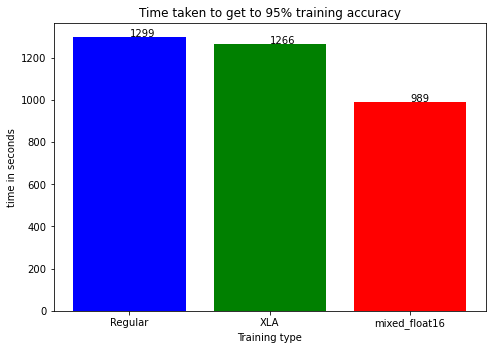

In [131]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
run_type = ['Regular', 'XLA', 'mixed_float16']
train_time = [reg_time,XLA_time, mixed_time]
colors = ['b','g','r']
for i,v in enumerate(train_time):
    ax.bar(run_type[i],train_time[i], color=colors[i])
    ax.text(i,train_time[i],str(train_time[i]))

ax.set_xlabel("Training type")
ax.set_ylabel("time in seconds")
ax.set_title('Time taken to get to 95% training accuracy')
plt.show()

In [86]:
base = 1.00

In [88]:
xla_change =reg_time/XLA_time

2.6% training speed decrease.

In [89]:
float16_change = reg_time/mixed_time

31.34% training speed decrease.

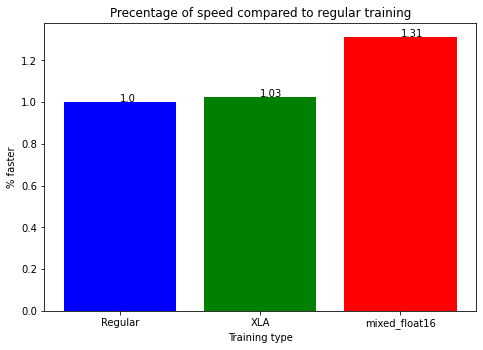

In [134]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
percent_time = [base,xla_change, float16_change]
colors = ['b','g','r']
for i,v in enumerate(percent_time):
    ax.bar(run_type[i],percent_time[i], color=colors[i])
    ax.text(i,percent_time[i],str(np.round(percent_time[i],2)))
ax.set_xlabel("Training type")
ax.set_ylabel("% faster")
ax.set_title('Precentage of speed compared to regular training')
plt.show()

# Conclusion

In this small experiment we can see that XLA and mixed precision training decreases training time while keeping accuracy about the same or better. Since this is a relatively a small model we probably don't see a big difference in training time as I have done other experiments that can give XLA about a 15% training time decrease. In mixed precision training I was able to actually get a 300% time decreased (16 min vs 5 min) but that was when I was testing with random weights. But in most beginning models the starting weights are going to be random so it should be fine.

In this experiment we did not see a drastic improvement most likely because of model size and hardware limitations. When checking information online it seems that XLA was tested with parallel GPU hardware on a much bigger model known as BERT.
https://www.tensorflow.org/xla

For mixed-precision training, again since its a relatively small model it is probably using more time doing other processes in training than doing calculation.

Nevertheless, there are improvements when using these two methods. I have tried training with XLA and mixed precision but have so far failed to do so. More experiment will be done to explore on this training methods.